In [ ]:
!pip install tensorflow==2.5.0
!pip install opencv-python
!pip install matplotlib
!pip install scikit-learn
import tensorflow as tf
from tensorflow.keras import layers


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.5.0

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available:

2025-04-25 21:51:11.781345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 21:51:11.781489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 21:51:12.045611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 21:51:12.758960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 21:51:18.891189: W tensorflow/compiler/tf2

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

dataset_root = "Structured3D" 

def load_first_n_rgb_and_depth_pairs(root_dir, max_samples=20):
    images = []
    depths = []
    count = 0

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if "rgb_rawlight.png" in filenames and "depth.png" in filenames:
            rgb_path = os.path.join(dirpath, "rgb_rawlight.png")
            depth_path = os.path.join(dirpath, "depth.png")


            img = cv2.imread(rgb_path)
            depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

            if img is None or depth is None:
                continue

            img = cv2.resize(img, (256, 256))
            depth = cv2.resize(depth, (256, 256))


            images.append(img)
            depths.append(depth)

            count += 1

            if count >= max_samples:
                break

    print(f"✅ Loaded {len(images)} image-depth pairs (max allowed: {max_samples}).")

    if not images:
        raise ValueError("❌ No valid rgb_rawlight-depth pairs found!")


    images = np.array(images, dtype=np.float32) / 255.0
    depths = np.array(depths, dtype=np.float32)
    max_depth = np.max(depths)


    if max_depth > 0:
        depths /= max_depth
    else:
        print("⚠️ All depth maps are empty.")

    return images, depths


images, depths = load_first_n_rgb_and_depth_pairs(dataset_root, max_samples=100)
X_train, X_test, y_train, y_test = train_test_split(images, depths, test_size=0.1, random_state=42)


✅ Loaded 100 image-depth pairs (max allowed: 100).


In [ ]:
def build_generator():
    inputs = tf.keras.Input(shape=(256, 256, 3))
    # Encoder
    e1 = layers.Conv2D(64, 4, 2, 'same')(inputs)
    e1 = layers.LeakyReLU(0.2)(e1)
    e2 = layers.Conv2D(128, 4, 2, 'same')(e1)
    e2 = layers.LeakyReLU(0.2)(e2)
    e3 = layers.Conv2D(256, 4, 2, 'same')(e2)
    e3 = layers.LeakyReLU(0.2)(e3)
    e4 = layers.Conv2D(512, 4, 2, 'same')(e3)
    e4 = layers.LeakyReLU(0.2)(e4)
    # Decoder
    d1 = layers.Conv2DTranspose(256, 4, 2, 'same')(e4)
    d1 = layers.ReLU()(d1)
    d1 = layers.Concatenate()([d1, e3])
    d2 = layers.Conv2DTranspose(128, 4, 2, 'same')(d1)
    d2 = layers.ReLU()(d2)
    d2 = layers.Concatenate()([d2, e2])
    d3 = layers.Conv2DTranspose(64, 4, 2, 'same')(d2)
    d3 = layers.ReLU()(d3)
    d3 = layers.Concatenate()([d3, e1])
    d4 = layers.Conv2DTranspose(32, 4, 2, 'same')(d3)
    d4 = layers.ReLU()(d4)
    outputs = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(d4)
    return tf.keras.Model(inputs, outputs)



def build_discriminator():
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(256, 256, 4)),  
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')  
    ])
    return model


def build_gan(generator, discriminator):

    discriminator.trainable = True    
    gan_input = tf.keras.Input(shape=(256, 256, 3))
    generated_depth = generator(gan_input)
    combined_input = tf.keras.layers.Concatenate(axis=-1)([gan_input, generated_depth])
    gan_output = discriminator(combined_input)
    gan_model = tf.keras.Model(gan_input, gan_output)
    
    return gan_model

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)


print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()

print("\nGAN Summary:")
gan.summary()


history = {
    'd_loss_real': [],
    'd_loss_fake': [],
    'd_acc_real': [],
    'd_acc_fake': [],
    'g_loss': []
}



def train_depth_gan(generator, discriminator, gan, X_train, y_train, epochs, batch_size=16):

    for epoch in range(epochs):
        d_losses_real = []
        d_losses_fake = []
        g_losses = []
        d_accs_real = []
        d_accs_fake = []
        

        indices = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, X_train.shape[0], batch_size):
            batch_end = min(i + batch_size, X_train.shape[0])
            batch_size_actual = batch_end - i
            

            real_images = X_shuffled[i:batch_end]
            real_depths = y_shuffled[i:batch_end]
            
            if len(real_depths.shape) == 3:
                real_depths = np.expand_dims(real_depths, axis=-1)

            fake_depths = generator.predict(real_images, verbose=0)
            real_combined = np.concatenate([real_images, real_depths], axis=-1)
            fake_combined = np.concatenate([real_images, fake_depths], axis=-1)
            real_labels = np.random.uniform(0.8, 1.0, size=(batch_size_actual, 1))  
            fake_labels = np.random.uniform(0.0, 0.2, size=(batch_size_actual, 1))  
            

            discriminator.trainable = True
            if i % 3 == 0:  
                d_loss_real = discriminator.train_on_batch(real_combined, real_labels)
                d_loss_fake = discriminator.train_on_batch(fake_combined, fake_labels)
            else:

                d_loss_real = discriminator.test_on_batch(real_combined, real_labels)
                d_loss_fake = discriminator.test_on_batch(fake_combined, fake_labels)
            

            discriminator.trainable = False
            gan_labels = np.ones((batch_size_actual, 1)) * 0.9 
            g_loss = gan.train_on_batch(real_images, gan_labels)
            if i % 2 == 0:  
                g_loss_extra = gan.train_on_batch(real_images, gan_labels)
                g_loss = (g_loss + g_loss_extra) / 2  

            d_losses_real.append(d_loss_real[0])
            d_losses_fake.append(d_loss_fake[0])
            d_accs_real.append(d_loss_real[1])
            d_accs_fake.append(d_loss_fake[1])
            g_losses.append(g_loss)

            if i % (10 * batch_size) == 0 and i > 0:
                print(f"Epoch {epoch+1}/{epochs} - Batch {i}/{X_train.shape[0]}")
                print(f"  D real: loss={np.mean(d_losses_real[-10:]):.4f}, acc={np.mean(d_accs_real[-10:]):.4f}")
                print(f"  D fake: loss={np.mean(d_losses_fake[-10:]):.4f}, acc={np.mean(d_accs_fake[-10:]):.4f}")
                print(f"  G loss: {np.mean(g_losses[-10:]):.4f}")
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"D loss real: {np.mean(d_losses_real):.4f}, D loss fake: {np.mean(d_losses_fake):.4f}")
        print(f"D accuracy real: {np.mean(d_accs_real):.4f}, D accuracy fake: {np.mean(d_accs_fake):.4f}")
        print(f"G loss: {np.mean(g_losses):.4f}")
        
        print("-" * 30)
        history['d_loss_real'].append(np.mean(d_losses_real))
        history['d_loss_fake'].append(np.mean(d_losses_fake))
        history['d_acc_real'].append(np.mean(d_accs_real))
        history['d_acc_fake'].append(np.mean(d_accs_fake))
        history['g_loss'].append(np.mean(g_losses))

train_depth_gan(generator, discriminator, gan, X_train, y_train, epochs=10, batch_size=32)




Generator Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         3136      ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu[0][0]']         
                                                                           

2025-04-25 21:52:01.178296: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-04-25 21:52:01.286537: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-04-25 21:52:15.320648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-04-25 21:52:15.403124: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-04-25 21:52:19.442633: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


Epoch 1/10
D loss real: 0.4316, D loss fake: 2.4201
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3790
------------------------------
Epoch 2/10
D loss real: 0.3473, D loss fake: 2.0891
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3901
------------------------------
Epoch 3/10
D loss real: 0.3464, D loss fake: 2.1295
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3720
------------------------------
Epoch 4/10
D loss real: 0.2938, D loss fake: 2.0877
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3672
------------------------------
Epoch 5/10
D loss real: 0.3263, D loss fake: 2.0727
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3631
------------------------------
Epoch 6/10
D loss real: 0.3518, D loss fake: 2.1037
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3611
------------------------------
Epoch 7/10
D loss real: 0.3416, D loss fake: 2.0729
D accuracy real: 0.0000, D accuracy fake: 0.0000
G loss: 0.3592
--

NameError: name 'epochs' is not defined

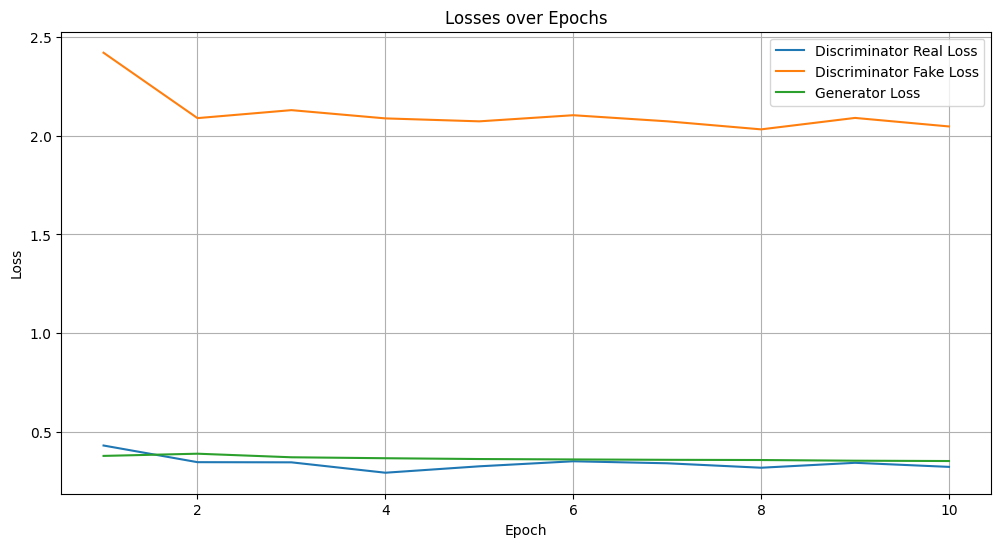

In [5]:
import matplotlib.pyplot as plt

epochs_range = range(1, 11)

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['d_loss_real'], label='Discriminator Real Loss')
plt.plot(epochs_range, history['d_loss_fake'], label='Discriminator Fake Loss')
plt.plot(epochs_range, history['g_loss'], label='Generator Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')
gan.save('gan_model.h5')

print("✅ All models saved successfully.")


✅ All models saved successfully.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the results directory if it doesn't exist
results_dir = 'DepthGAN_RESULTS'
os.makedirs(results_dir, exist_ok=True)

# Function to compute Mean Absolute Error (MAE)
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to compute Root Mean Squared Error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

# Function to compute Logarithmic Root Mean Squared Error (RMSElog)
def rmse_log(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log(y_true + 1e-6) - np.log(y_pred + 1e-6))))

# Function to compute Absolute Relative Error (AbsRel)
def absolute_relative_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + 1e-6))

# Function to compute Square Relative Error (SqRel)
def square_relative_error(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred) / (y_true + 1e-6)))

# Function to compute Threshold Percentage (δ)
def threshold_percentage(y_true, y_pred, threshold=1.25):
    ratio = np.maximum(y_true / y_pred, y_pred / y_true)
    return np.mean(ratio < threshold)

# Evaluate the metrics and save results
def evaluate_and_save_results(X_test, y_test, generator, num_samples=5):
    for i in range(min(num_samples, len(X_test))):
        sample_img = X_test[i:i+1]
        true_depth = y_test[i:i+1]
        
        # Ensure true_depth has correct shape
        if len(true_depth.shape) == 3:
            true_depth = np.expand_dims(true_depth, axis=-1)
        
        # Generate depth prediction
        generated_depth = generator.predict(sample_img, verbose=0)
        
        # Calculate metrics
        y_true = true_depth.reshape(-1)  # Flatten for metrics calculation
        y_pred = generated_depth.reshape(-1)  # Flatten for metrics calculation
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)
        rmse_log_val = rmse_log(y_true, y_pred)
        abs_rel = absolute_relative_error(y_true, y_pred)
        sq_rel = square_relative_error(y_true, y_pred)
        thres_1_25 = threshold_percentage(y_true, y_pred, threshold=1.25)
        thres_1_25_2 = threshold_percentage(y_true, y_pred, threshold=1.25**2)
        thres_1_25_3 = threshold_percentage(y_true, y_pred, threshold=1.25**3)
        
        # Create metrics string
        metrics_text = f"""Sample {i+1} Metrics:
Mean Absolute Error (MAE): {mae:.6f}
Root Mean Squared Error (RMSE): {rmse:.6f}
Logarithmic RMSE (RMSElog): {rmse_log_val:.6f}
Absolute Relative Error (AbsRel): {abs_rel:.6f}
Square Relative Error (SqRel): {sq_rel:.6f}
Threshold < 1.25: {thres_1_25 * 100:.2f}%
Threshold < 1.25^2: {thres_1_25_2 * 100:.2f}%
Threshold < 1.25^3: {thres_1_25_3 * 100:.2f}%
"""
        
        # Print metrics to console
        print(metrics_text)
        
        # Save metrics to file
        with open(os.path.join(results_dir, f'metrics_sample_{i+1}.txt'), 'w') as f:
            f.write(metrics_text)
        
        # Save visualizations
        plt.figure(figsize=(15, 5))
        
        # RGB image
        plt.subplot(1, 3, 1)
        plt.imshow(sample_img[0])
        plt.title('RGB Image')
        plt.axis('off')
        
        # Ground truth depth
        plt.subplot(1, 3, 2)
        plt.imshow(true_depth[0, :, :, 0], cmap='viridis')
        plt.title('Ground Truth Depth')
        plt.axis('off')
        
        # Predicted depth
        plt.subplot(1, 3, 3)
        plt.imshow(generated_depth[0, :, :, 0], cmap='viridis')
        plt.title('Predicted Depth')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'visualization_sample_{i+1}.png'), dpi=300)
        plt.close()
        
        # Save individual images
        plt.figure(figsize=(5, 5))
        plt.imshow(sample_img[0])
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'rgb_sample_{i+1}.png'), dpi=300)
        plt.close()
        
        plt.figure(figsize=(5, 5))
        plt.imshow(true_depth[0, :, :, 0], cmap='viridis')
        plt.axis('off')
        plt.colorbar(label='Depth')
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'true_depth_sample_{i+1}.png'), dpi=300)
        plt.close()
        
        plt.figure(figsize=(5, 5))
        plt.imshow(generated_depth[0, :, :, 0], cmap='viridis')
        plt.axis('off')
        plt.colorbar(label='Depth')
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, f'predicted_depth_sample_{i+1}.png'), dpi=300)
        plt.close()
        
        # Save depth maps as numpy arrays
        np.save(os.path.join(results_dir, f'true_depth_sample_{i+1}.npy'), true_depth[0, :, :, 0])
        np.save(os.path.join(results_dir, f'predicted_depth_sample_{i+1}.npy'), generated_depth[0, :, :, 0])
    
    # Calculate and save average metrics across all test samples
    if num_samples > 1:
        print("\nCalculating average metrics across all samples...")
        all_true_depths = []
        all_pred_depths = []
        
        for i in range(min(num_samples, len(X_test))):
            sample_img = X_test[i:i+1]
            true_depth = y_test[i:i+1]
            
            # Ensure true_depth has correct shape
            if len(true_depth.shape) == 3:
                true_depth = np.expand_dims(true_depth, axis=-1)
            
            # Generate depth prediction
            generated_depth = generator.predict(sample_img, verbose=0)
            
            all_true_depths.append(true_depth.reshape(-1))
            all_pred_depths.append(generated_depth.reshape(-1))
        
        # Concatenate all depths
        all_true_depths = np.concatenate(all_true_depths)
        all_pred_depths = np.concatenate(all_pred_depths)
        
        # Calculate average metrics
        avg_mae = mean_absolute_error(all_true_depths, all_pred_depths)
        avg_rmse = root_mean_squared_error(all_true_depths, all_pred_depths)
        avg_rmse_log = rmse_log(all_true_depths, all_pred_depths)
        avg_abs_rel = absolute_relative_error(all_true_depths, all_pred_depths)
        avg_sq_rel = square_relative_error(all_true_depths, all_pred_depths)
        avg_thres_1_25 = threshold_percentage(all_true_depths, all_pred_depths, threshold=1.25)
        avg_thres_1_25_2 = threshold_percentage(all_true_depths, all_pred_depths, threshold=1.25**2)
        avg_thres_1_25_3 = threshold_percentage(all_true_depths, all_pred_depths, threshold=1.25**3)
        
        # Create average metrics string
        avg_metrics_text = f"""Average Metrics Across {min(num_samples, len(X_test))} Samples:
Mean Absolute Error (MAE): {avg_mae:.6f}
Root Mean Squared Error (RMSE): {avg_rmse:.6f}
Logarithmic RMSE (RMSElog): {avg_rmse_log:.6f}
Absolute Relative Error (AbsRel): {avg_abs_rel:.6f}
Square Relative Error (SqRel): {avg_sq_rel:.6f}
Threshold < 1.25: {avg_thres_1_25 * 100:.2f}%
Threshold < 1.25^2: {avg_thres_1_25_2 * 100:.2f}%
Threshold < 1.25^3: {avg_thres_1_25_3 * 100:.2f}%
"""
        
        # Print average metrics to console
        print(avg_metrics_text)
        
        # Save average metrics to file
        with open(os.path.join(results_dir, 'average_metrics.txt'), 'w') as f:
            f.write(avg_metrics_text)


# Usage example:
evaluate_and_save_results(X_test, y_test, generator, num_samples=1)

Sample 1 Metrics:
Mean Absolute Error (MAE): 0.334428
Root Mean Squared Error (RMSE): 0.339940
Logarithmic RMSE (RMSElog): 1.142358
Absolute Relative Error (AbsRel): 2.150799
Square Relative Error (SqRel): 5.664864
Threshold < 1.25: 0.00%
Threshold < 1.25^2: 1.30%
Threshold < 1.25^3: 10.55%



1/1 [==============================] - 0s 165ms/step


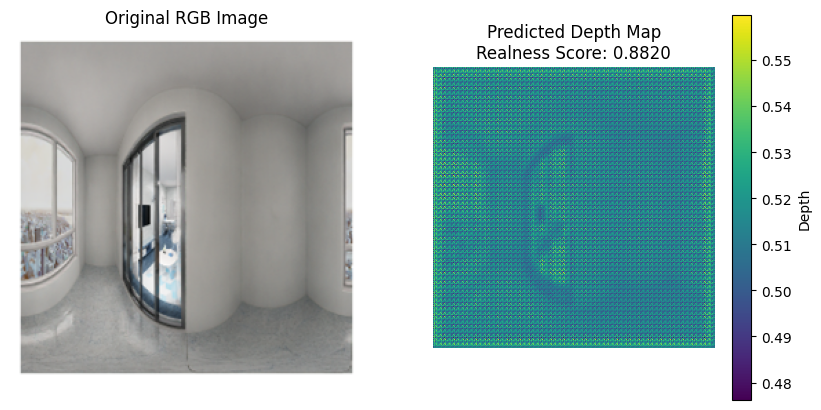

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# === Step 1: Upload and preprocess the image ===
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).resize((256, 256)).convert('RGB')
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0) 

# === Step 2: Generate Depth Map ===
def generate_depth(generator, rgb_image):
    depth_map = generator.predict(rgb_image)
    return depth_map[0] 

# === Step 3: Evaluate Realness of Depth Map ===

def evaluate_discriminator(discriminator, rgb_image, depth_map):

    if rgb_image.ndim == 4:
        rgb_image = rgb_image[0]  

    if depth_map.ndim == 4:
        depth_map = depth_map[0]  

    if depth_map.shape[-1] != 1:
        depth_map = np.expand_dims(depth_map[..., 0], axis=-1)

    if depth_map.shape[:2] != rgb_image.shape[:2]:
        depth_map = tf.image.resize(depth_map, (rgb_image.shape[0], rgb_image.shape[1])).numpy()
    combined_input = np.concatenate([rgb_image, depth_map], axis=-1)  
    combined_input = np.expand_dims(combined_input, axis=0)  

    score = discriminator.predict(combined_input)
    return score[0][0]


# === Step 4: Visualization and Execution ===
def run_depth_prediction(img_path, generator, discriminator):
    rgb = load_and_preprocess_image(img_path)
    depth = generate_depth(generator, rgb)
    score = evaluate_discriminator(discriminator, rgb, depth)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original RGB Image')
    plt.imshow(rgb[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'Predicted Depth Map\nRealness Score: {score:.4f}')
  
    plt.imshow(depth.squeeze(), cmap='viridis')  
    plt.colorbar(label='Depth') 
    plt.axis('off')
    plt.show()

#img_path = 'rgb_sample_4.png'
#run_depth_prediction(img_path, generator, discriminator)
